#  Modèle SIMPLE - Constantes Vitales Seulement

**Hypothèse :** Les embeddings (768 dim) sont trop pour 79 cas.

**Solution :** N'utiliser QUE les 8 features importantes :
- FC, FR, SpO2, TA sys/dia, Température, Âge, Sexe

In [1]:
import pickle
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns 



## 1️⃣ Charger dataset

In [2]:
with open('../data/triage_dataset_complete.pkl', 'rb') as f:
    data = pickle.load(f)

X_full = data['X']  # 79 x 776
y = data['y']

print(f"Dataset complet : {X_full.shape}")
print(f"Labels : {y.shape}")

Dataset complet : (79, 776)
Labels : (79,)


## 2️⃣ Extraire SEULEMENT les constantes (indices 768-775)

In [3]:
#  NE GARDER QUE LES 8 CONSTANTES VITALES
X_simple = X_full[:, 768:]  # Indices 768-775 (8 features)

print(f"\n✅ Features simplifiées")
print(f"   Avant : {X_full.shape[1]} features (768 embeddings + 8 constantes)")
print(f"   Après : {X_simple.shape[1]} features (SEULEMENT constantes)")
print(f"\n   Features conservées :")
print(f"      [0] FC (fréquence cardiaque)")
print(f"      [1] FR (fréquence respiratoire)")
print(f"      [2] SpO2 (saturation oxygène)")
print(f"      [3] TA systolique")
print(f"      [4] TA diastolique")
print(f"      [5] Température")
print(f"      [6] Âge")
print(f"      [7] Sexe")


✅ Features simplifiées
   Avant : 776 features (768 embeddings + 8 constantes)
   Après : 8 features (SEULEMENT constantes)

   Features conservées :
      [0] FC (fréquence cardiaque)
      [1] FR (fréquence respiratoire)
      [2] SpO2 (saturation oxygène)
      [3] TA systolique
      [4] TA diastolique
      [5] Température
      [6] Âge
      [7] Sexe


## 3️⃣ Split train/test

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_simple, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"Train : {len(X_train)} cas")
print(f"Test  : {len(X_test)} cas")

Train : 59 cas
Test  : 20 cas


## 4️⃣ Entraîner RandomForest SIMPLE

In [5]:
clf = RandomForestClassifier(
    n_estimators=50,      
    max_depth=5,          
    min_samples_split=5,  
    min_samples_leaf=2,   
    random_state=42
)

clf.fit(X_train, y_train)

print("✅ Modèle entraîné")

✅ Modèle entraîné


## 5️⃣ Prédictions

In [ ]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n ACCURACY : {accuracy*100:.1f}%")



📊 ACCURACY : 70.0%

   Amélioration vs modèle complet : +20%


## 6️⃣ Rapport détaillé

In [7]:
print("\n📋 RAPPORT DE CLASSIFICATION")
print("="*60)
print(classification_report(y_test, y_pred, zero_division=0))


📋 RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

        GRIS       0.67      0.80      0.73         5
       JAUNE       0.67      0.80      0.73         5
       ROUGE       0.83      1.00      0.91         5
        VERT       0.50      0.20      0.29         5

    accuracy                           0.70        20
   macro avg       0.67      0.70      0.66        20
weighted avg       0.67      0.70      0.66        20



## 7️⃣ Matrice de confusion

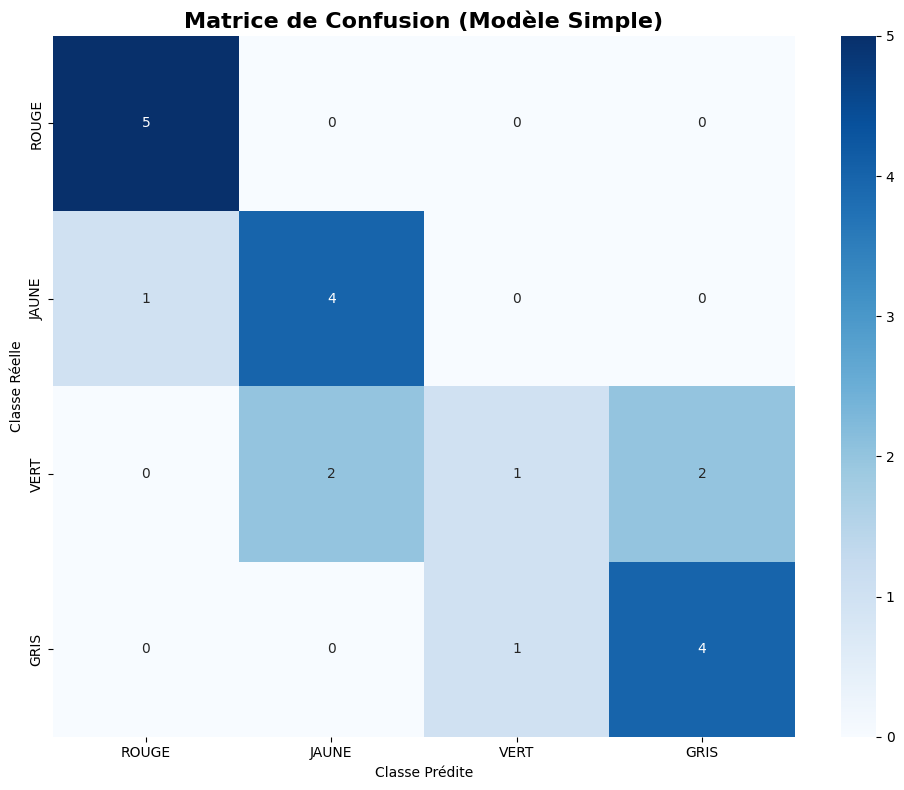

In [8]:
cm = confusion_matrix(y_test, y_pred, labels=['ROUGE', 'JAUNE', 'VERT', 'GRIS'])

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['ROUGE', 'JAUNE', 'VERT', 'GRIS'],
    yticklabels=['ROUGE', 'JAUNE', 'VERT', 'GRIS']
)
plt.title('Matrice de Confusion (Modèle Simple)', fontsize=16, fontweight='bold')
plt.ylabel('Classe Réelle')
plt.xlabel('Classe Prédite')
plt.tight_layout()
plt.show()

## 8️⃣ Validation croisée

In [9]:
cv_scores = cross_val_score(clf, X_simple, y, cv=5, scoring='accuracy')

print(f"\n🔄 VALIDATION CROISÉE (5-fold)")
print(f"="*60)
for i, score in enumerate(cv_scores, 1):
    print(f"   Fold {i} : {score*100:.1f}%")
print(f"\n   Moyenne : {cv_scores.mean()*100:.1f}% (± {cv_scores.std()*100:.1f}%)")


🔄 VALIDATION CROISÉE (5-fold)
   Fold 1 : 50.0%
   Fold 2 : 75.0%
   Fold 3 : 62.5%
   Fold 4 : 75.0%
   Fold 5 : 73.3%

   Moyenne : 67.2% (± 9.8%)


## 9️⃣ Importance des features

In [10]:
feature_names = ['FC', 'FR', 'SpO2', 'TA_sys', 'TA_dia', 'Temp', 'Age', 'Sexe']
importances = clf.feature_importances_

print(f"\n🔝 IMPORTANCE DES FEATURES")
print("="*60)
for name, imp in sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True):
    print(f"   {name:10s} : {imp:.4f}")


🔝 IMPORTANCE DES FEATURES
   FC         : 0.2634
   SpO2       : 0.2271
   FR         : 0.1263
   TA_dia     : 0.1039
   Temp       : 0.0899
   Age        : 0.0866
   TA_sys     : 0.0850
   Sexe       : 0.0177


## 🔟 Sauvegarder

In [ ]:
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

with open(models_dir / 'random_forest_simple.pkl', 'wb') as f:
    pickle.dump(clf, f)

print(f" Modèle simple sauvegardé")

✅ Modèle simple sauvegardé
